In [1]:
import pandas as pd
import os
import datetime
import re
import pyarrow.parquet as pq
import holidays

### convert datetime to two separate columns date and time 

In [2]:
def feature_eng(df, column):
    df['pickup_date'] = [d.date() for d in pd.to_datetime(df[column])]
    df.drop(column, axis=1, inplace=True)
    df['count'] = 1
    return df

In [3]:
def get_files_list(path):
    return os.listdir(path)

In [4]:
def update_list_files():
    list_files = get_files_list('data/')
    list_output = get_files_list('new_data/')
    list_output = [item.replace('.csv', '') for item in list_output]
    for file in list_output:
        #print(file)
        if file in list_files:
            list_files.remove(file)
            #print(len(list_files))
    return list_files

In [5]:
def add_holiday_column(dataset):
    us_NY_holidays = holidays.country_holidays('US', subdiv='NY')
    dataset['holiday'] = False
    dataset['holiday'] = [True if d in us_NY_holidays else False for d in dataset['pickup_date'] ]
    return dataset

In [68]:
def add_weekday(dataset):
    dataset['weekday'] = 0
    dataset['weekday'] = [d.weekday() for d in pd.to_datetime(dataset['pickup_date'])]
    return dataset

In [112]:
def trim_df(dataset):
    dataset = dataset[dataset['pickup_date'] < '2022-05-01']
    dataset = dataset[dataset['pickup_date'] > '2014-12-31']
    return dataset

### create light files

In [69]:
list_files = update_list_files()
print('number of files to read: ', len(list_files))
for file_name in list_files:
    print('reading {} file'.format(file_name))
    pfile = pq.read_table('data/' + file_name)
    #print("Column names: {}".format(pfile.column_names))
    column = [item for item in pfile.column_names if 'pickup_datetime' in item.lower()][0]
    f =  pd.read_parquet('data/' + file_name, engine='pyarrow', columns = [column])
    
    f = feature_eng(f, column)
    f = f.groupby('pickup_date').count()
    f.to_csv('new_data/' + file_name + '.csv')        

number of files to read:  0


### load and concatenate files

In [114]:
if not os.path.exists('aggregated_files.xlsx'):
    full_df = pd.DataFrame()
    list_files = get_files_list('new_data/')
    for file_name in list_files:
        if 'fhvhv_' not in file_name:
            f =  pd.read_csv('new_data/' + file_name)
            #taxi_type = re.split('_', file_name)[0]
            #f['type'] = taxi_type
            full_df = full_df.append(f)
    full_df = trim_df(full_df)
    final_dataset = add_holiday_column(full_df)
    final_dataset = add_weekday(final_dataset)
    final_dataset = full_df.groupby('pickup_date', as_index=False, sort=False).agg({'count': \
                                                                    'sum', 'holiday': 'first', 'weekday': 'first'})
    final_dataset.to_excel('aggregated_files.xlsx')
else:
    final_dataset = pd.read_excel('aggregated_files.xlsx')

Index(['pickup_date', 'count', 'holiday', 'weekday'], dtype='object')


<AxesSubplot:>

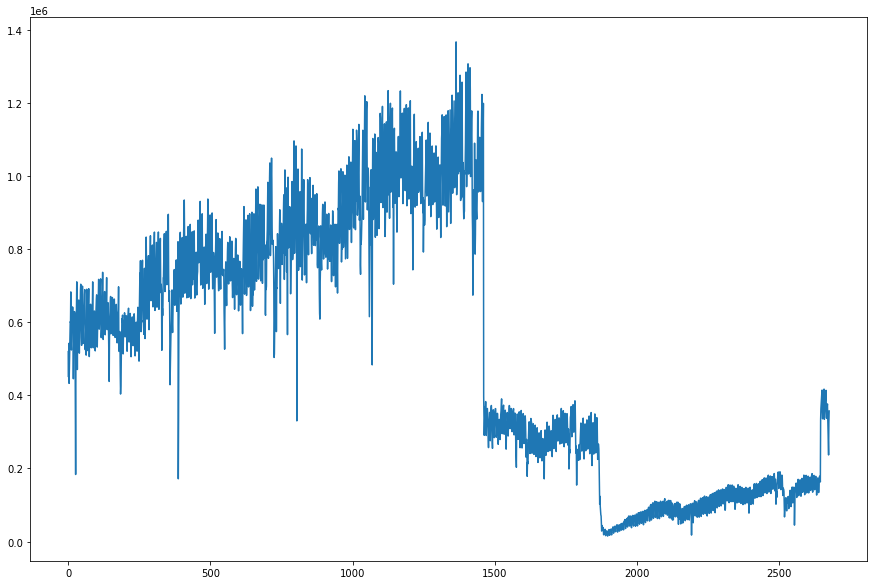

In [115]:
# final_dataset.set_index('pickup_date', inplace=True) #set Date as index
final_dataset['count'].plot( figsize=(15, 10)) #plot